# Impacts of Cyclone Alfred on Gold Coast
## Main Processi Over Sentinel-2C Data Cube

The ### on comments indicate the necessary cells to avoid Kernel restarting  <br /> 
Use section [Change and Tendency Maps](#change) for analysis, it loads the data after running the notebook once.
#### load_data
Load data section

In [1]:
###
#Main libraries
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

#DEA tools
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map


#Other Tools
%matplotlib inline
from rasterio.features import geometry_mask, shapes
from shapely.geometry import shape
import pickle


#Plotting
from datacube.utils import masking
from matplotlib.colors import LinearSegmentedColormap

In [2]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
###
# Connect to the data cube and provide a string to identify this application and track down problems with database queries
dc = datacube.Datacube(app="Sentinel2_ARD")

In [4]:
###
# Define AOI
nlon_range = (153.16,153.56)
nlat_range = (-27.6,-28.28)

In [5]:
display_map(x=nlon_range, y=nlat_range)

In [6]:
###
# Create a query object containing parameters used to search for and load Sentinel-2 data
query = {
    "x": nlon_range,
    "y": nlat_range,
    "time": ("2025-01-01", "2025-07-31"),
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    #Join images taken on the same day as one scene
    "group_by": "solar_day",
}

In [7]:
###
# load ARD with cloud cover set to 25% and cloud masking
bands = ["nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "oa_s2cloudless_mask", "oa_s2cloudless_prob"]

ds = load_ard(dc=dc,
              products=[ "ga_s2cm_ard_3"],
              measurements=bands,
              cloud_mask='s2cloudless',
              mask_pixel_quality=True,
              min_gooddata=0.70,
              dask_chunks={"time": 1},
              **query)


Finding datasets
    ga_s2cm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 7 out of 37 time steps with at least 70.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 7 time steps as a dask array


In [8]:
#The result of dc load is a xarray.Dataset x and y are the number of pixels in that axis, time are the timesteps returned by the query 
ds

<xarray.Dataset> Size: 6GB
Dimensions:              (time: 7, y: 8171, x: 5105)
Coordinates:
  * time                 (time) datetime64[ns] 56B 2025-02-08T23:54:50.314929...
  * y                    (y) float64 65kB -3.165e+06 -3.165e+06 ... -3.246e+06
  * x                    (x) float64 41kB 2.041e+06 2.041e+06 ... 2.092e+06
    spatial_ref          int32 4B 3577
Data variables:
    nbart_blue           (time, y, x) float32 1GB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
    nbart_green          (time, y, x) float32 1GB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
    nbart_red            (time, y, x) float32 1GB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
    nbart_nir_1          (time, y, x) float32 1GB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
    oa_s2cloudless_mask  (time, y, x) uint8 292MB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
    oa_s2cloudless_prob  (time, y, x) float32 1GB dask.array<chunksize=(1, 8171, 5105), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [9]:
###
#Saving images dataset to directory
with open("ds.pkl", "wb") as f:
    pickle.dump(ds, f)

In [ ]:
#Plotting Images
# Set the band combination to plot
plot_bands = ['nbart_red', 'nbart_green', 'nbart_blue']

# Loop through each timestep and plot individually
for i in range(len(ds.time)):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Select the current timestep
    timestep_ds = ds.isel(time=i)
    
    # Format the time stamp for use as the plot title
    time_string = str(timestep_ds.time.values).split("T")[0]
    
    # Set the title and axis labels
    ax.set_title(f"Timestep {time_string}", fontweight='bold', fontsize=16)
    ax.set_xlabel('Easting (m)', fontweight='bold')
    ax.set_ylabel('Northing (m)', fontweight='bold')
    
    # Generate the image by running the rgb function
    rgb(timestep_ds, bands=plot_bands, ax=ax)


## Water bodies and mangroves mask

### Water bodies mask

#### Using Land Cover

In [11]:
###
# USING LAND COVER DATASET
#Load DEA Land Cover data for 2024
lc = dc.load(
    x = nlon_range,
    y= nlat_range,
    product="ga_ls_landcover_class_cyear_3",
    measurements=[
        "level3",
        "level4"],
    resolution=(-30, 30),
    time="2024"
)

# Create mask for water classes: 220 (Water)
water_mask = (lc.level3 == 220)

# Convert raster to boolean uint8 for shapes()
water_mask_np = water_mask.squeeze().values.astype(np.uint8)

# Extract from raster AOI
shapes_gen = shapes(water_mask_np, transform=lc.geobox.transform)

# List geometry with shapely
geoms = [shape(geom) for geom, value in shapes_gen if value == 1]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geoms, crs=lc.geobox.crs)

In [ ]:
water_mask.plot()

In [12]:
###
# Create mask
mask = geometry_mask(
    geometries=gdf.geometry,
    out_shape=(ds.sizes['y'], ds.sizes['x']),
    transform=ds.geobox.transform,
    invert=True  # True para mantener el interior de los polígonos
)

# Apply mask
wb_ds = ds.where(xr.DataArray(mask, dims=("y", "x")))

In [13]:
###
#Saving water masked dataset (LC)
with open("wb_ds.pkl", "wb") as f:
    pickle.dump(wb_ds, f)

In [ ]:
# Plot the masked dataset
plot_bands=['nbart_red', 'nbart_green', 'nbart_blue']
rgb(wb_ds, plot_bands, col="time", col_wrap=3)

### Mangroves mask

In [14]:
###
#Accessing data
dc = datacube.Datacube(app="DEA_Mangroves")

In [ ]:
#List measurements for Mangroves dc
dc_measurements = dc.list_measurements()
dc_measurements.loc[["ga_ls_mangrove_cover_cyear_3"]]

In [15]:
###
#Set up the query
mg_query = {
    "y": nlat_range,
    "x": nlon_range,
    "time":"2024",
}

In [16]:
###
#Getting Mangrove Cover Data
mangroves = dc.load(product="ga_ls_mangrove_cover_cyear_3", **mg_query)

In [ ]:
mangroves

In [17]:
###
# MASKING MANGROVES USING RASTERIO

# Extract the mangrove data for 2024
mangrove_mask = mangroves.canopy_cover_class.squeeze()  # Eliminar dimensión 'time'

# Keep woodland, open_forest y closed_forest classes
mangrove_values = [1, 2, 3]  # Ajusta según los valores reales en tu dataset

# Boolean mask for mangroves (True for mangrove cover)
mask = xr.where(mangrove_mask.isin(mangrove_values), True, False)

# 4. Masking the Sentinel-2 Dataset
mg_ds = ds.where(mask)

In [ ]:
# Plot the masked dataset
plot_bands=['nbart_red', 'nbart_green', 'nbart_blue']
rgb(mg_ds, plot_bands, col="time", col_wrap=3)

In [18]:
###
#Saving mangroves dataset to directory
with open("mg_ds.pkl", "wb") as f:
    pickle.dump(mg_ds, f)

# Calculating Indices

## NDTI

In [19]:
###
# Calculate the components that make up the NDTI index
band_diff_w = wb_ds.nbart_red - wb_ds.nbart_green
band_sum_w = wb_ds.nbart_red + wb_ds.nbart_green

#Calculate the NDTI and store it
ndti = band_diff_w/band_sum_w

In [20]:
###
# Saving the NDTI output
with open("ndti.pkl", "wb") as f:
    pickle.dump(ndti, f)

In [ ]:
# Plot the NDTI index
#Value ranges
ndti_min = float(ndti.min())
ndti_max = float(ndti.max())

ndti.plot(
    col="time",
    col_wrap=3,
    cmap="viridis",
    vmin=ndti_min,
    vmax=ndti_max,
    figsize=(15, 8),
    robust=True
)

## NDVI

In [21]:
###
# Calculate the components that make up the NDVI index
band_diff_v = mg_ds.nbart_nir_1 - mg_ds.nbart_red
band_sum_v = mg_ds.nbart_nir_1 + mg_ds.nbart_red
#Calculate the NDVI and store it
ndvi = band_diff_v/band_sum_v

In [22]:
###
#Saving NDVI
with open("ndvi.pkl", "wb") as f:
    pickle.dump(ndvi, f)

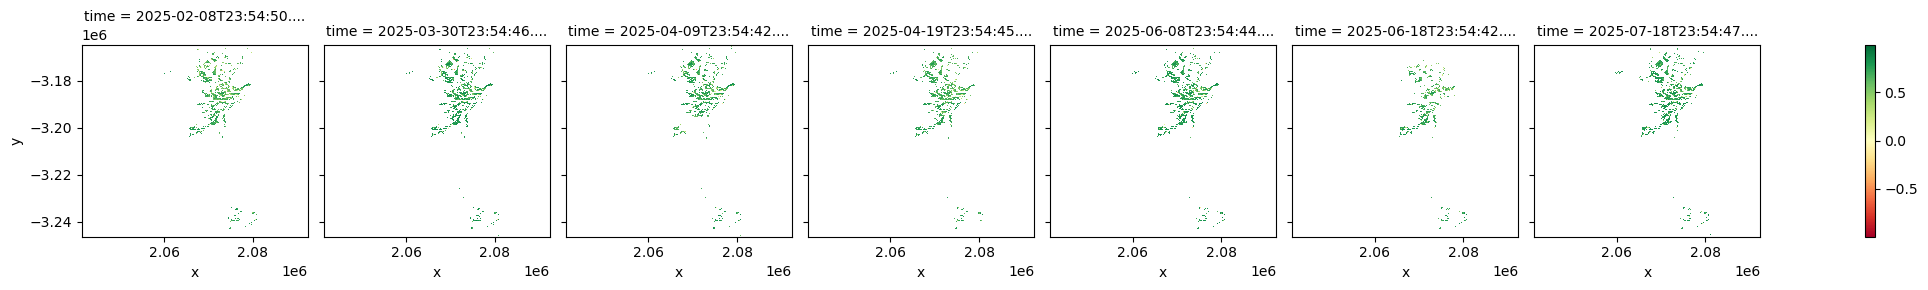

In [26]:
# Plot the NDVI index
ndvi.plot(col="time", cmap="RdYlGn")

In [23]:
###
# Caculate the EVI Index

G = 2.5
C1 = 6.0
C2 = 7.5
L = 1.0

nir = mg_ds.nbart_nir_1/10000
red = mg_ds.nbart_red/10000
blue = mg_ds.nbart_blue/10000

evi = G * (nir - red) / (nir + C1 * red - C2 * blue + L)

In [24]:
###
#Saving EVI
with open("evi.pkl", "wb") as f:
    pickle.dump(evi, f)

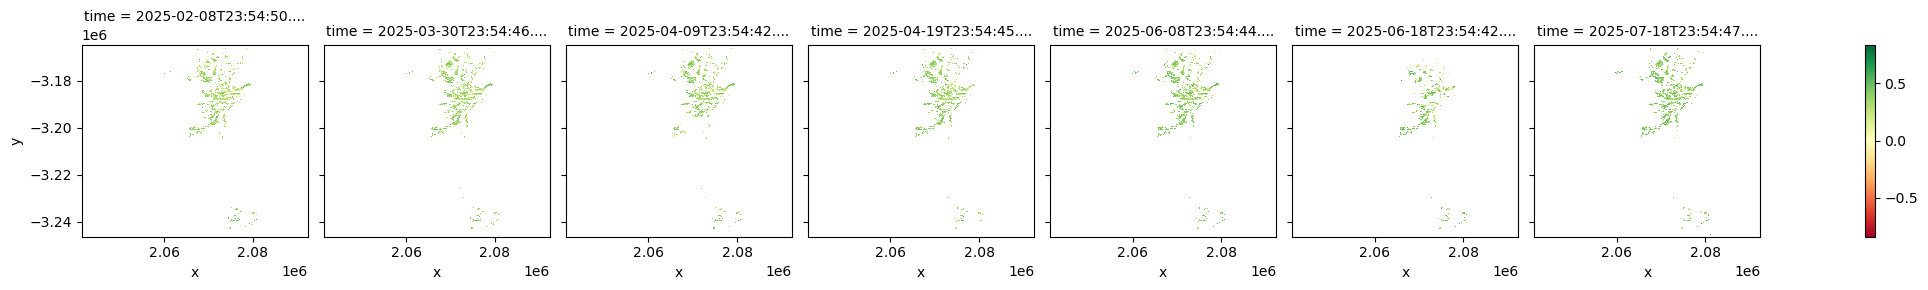

In [25]:
###
# Plot the EVI index
evi.plot(col="time", cmap="RdYlGn")

## change

In [ ]:
#Loading data when RAM runs out
datasets = {}

# Define the files to load (comment/uncomment as needed)
files_to_load = {
    'ndti': 'ndti.pkl',
    'wb_ds': 'wb_ds.pkl',
    'ndvi': 'ndvi.pkl',
    'evi': 'evi.pkl',
    'ds': 'ds.pkl',          
    'mg_ds': 'mg_ds.pkl'    
}

# Load each file and create a variable
for var_name, filepath in files_to_load.items():
    with open(filepath, 'rb') as f:
        globals()[var_name] = pickle.load(f)

## Turbidity Change Maps

In [ ]:
### Calculating Difference
ndti_diff = ndti.diff(dim='time')

In [ ]:
ndti_diff

In [ ]:
#Plotting

# Calculate the absolute maximum value for color scaling
diff_max = float(abs(ndti_diff).max())

# Iterate through each timestep and display the plot directly
for i in range(len(ndti_diff.time)):
    slice_i = ndti_diff.isel(time=i)
    plt.figure(figsize=(6, 4))
    slice_i.plot(cmap="coolwarm", vmin=-diff_max, vmax=diff_max)
    plt.title(f'NDTI Difference - Change Map {i+1}')
    plt.show()

In [ ]:
### Export NDTIDIFF raster for mapping in GIS
ndti_diff = ndti_diff.rio.write_crs("EPSG:3577")

for i, t in enumerate(ndti_diff.time):
    date = str(t.dt.strftime('%Y%m%d').values)  # format YYYYMMDD
    output = f"ndti_diff_{date}.tif"
    
    da_t = ndti_diff.sel(time=t)
    
    da_t.rio.to_raster(output)

    print(f"Saved: {output}")

## Vegetation Index Change Maps

In [28]:
### Calculating NDVI Difference
ndvi_diff = ndvi.diff(dim='time')

In [29]:
ndvi_diff = ndvi_diff*10

In [ ]:
### Export NDVIDIFF raster for mapping in GIS
ndvi_diff = ndvi_diff.rio.write_crs("EPSG:3577")

for i, t in enumerate(ndvi_diff.time):
    date = str(t.dt.strftime('%Y%m%d').values)  # format YYYYMMDD
    output = f"ndvi_diff_{date}.tif"
    
    da_t = ndvi_diff.sel(time=t)
    
    da_t.rio.to_raster(output)

    print(f"Saved: {output}")

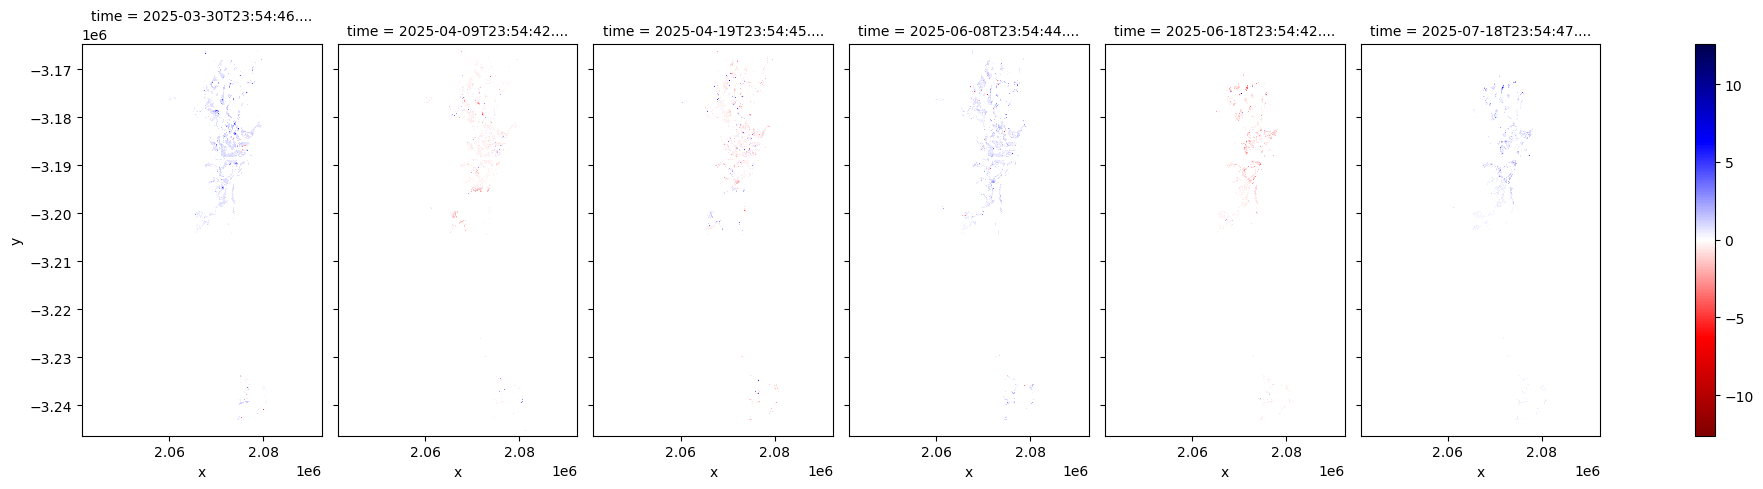

In [31]:
# Plot the difference map
diff_max = float(abs(ndvi_diff).max())
ndvi_diff.plot(col="time", cmap="seismic_r", figsize=(20, 5))

In [ ]:
### Calculating EVI Difference
evi_diff = evi.diff(dim='time')

In [ ]:
evi_diff

In [ ]:
evi_diff = evi_diff*1000

In [ ]:
# Plot the difference map
diff_max = float(abs(evi_diff).max())
evi_diff.plot(col="time", cmap="seismic", figsize=(20, 5))

In [ ]:
### Export NDVIDIFF raster for mapping in GIS
evi_diff = evi_diff.rio.write_crs("EPSG:3577")

for i, t in enumerate(ndvi_diff.time):
    date = str(t.dt.strftime('%Y%m%d').values)  # format YYYYMMDD
    output = f"evi_diff_{date}.tif"
    
    da_t = evi_diff.sel(time=t)
    
    da_t.rio.to_raster(output)

    print(f"Saved: {output}")

[Return to top of page](#load_data)